### STEP 1 : 시계열 데이터 준비
- 칼럼 종류: Date, Open, High, Low, Close, Adj Close, Volume
- 날짜별로 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)이 저장되어 있는 것을 확인할 수 있지만, 우리는 Close만 사용하겠습니다. (주식 시장은 정해진 시간 동안만 거래가 가능합니다. 종가란 하루의 장이 마감하였을 때의 가격입니다.)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

def load_data(name):
    dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/'+name
    df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
    ts = df['Close']
    ts.head()
    return ts

### STEP 2 : 각종 전처리 수행

- 결측치 처리
- 로그 변환

In [2]:
def preprocessing(name):
    ts = load_data(name)
    # 결측치 처리
    ts=ts.interpolate(method='time')
    ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.
    # 로그 변환 시도 
    ts_log = np.log(ts)
    plt.plot(ts_log)
    return ts_log

### STEP 3 : 시계열 안정성 분석

- 정성적 그래프 분석
- 정량적 Augmented Dicky-Fuller Test
- 시계열 분해(Time Series Decomposition)
- Residual 안정성 확인

In [3]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
print('슝=3')

슝=3


In [4]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
print('슝=3')

슝=3


In [5]:
def Safety_analysis(ts_log):
    # 정성적 그래프 분석
    plot_rolling_statistics(ts_log, window=12)

    #정량적 Augmented Dicky-Fuller Test
    augmented_dickey_fuller_test(ts_log)

    #시계열 분해 (Time Series Decomposition)
    from statsmodels.tsa.seasonal import seasonal_decompose
    decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    plt.subplot(411)
    plt.plot(ts_log, label='Original')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residuals')
    plt.legend(loc='best')
    plt.tight_layout()
    
    residual.dropna(inplace=True)
    augmented_dickey_fuller_test(residual)


### STEP 4 : 학습, 테스트 데이터셋 생성

- 학습, 테스트 데이터셋 분리

In [6]:
def data_split(ts_log):
    train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
    plt.figure(figsize=(10,6))
    plt.grid(True)
    plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
    plt.plot(test_data, c='b', label='test dataset')
    plt.legend()
    return train_data, test_data

### STEP 5 : 적정 ARIMA 모수 찾기

- ACF, PACF 그려보기 -> p,q 구하기
- 차분 안정성 확인 -> d 구하기

p : 자기회귀 모형(AR)의 시차를 의미<br/>
q : 이동 평균 모형(MA)의 시차를 의미<br/>
d : 차분 횟수를 의미

In [7]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
def find_parameter(ts_log):
    plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
    plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
    plt.show()

In [8]:
def parameter_safety(ts_log):
    # 차분 안정성 확인 -> d 구하기
    # 1차 차분 구하기
    diff_1 = ts_log.diff(periods=1).iloc[1:]
    diff_1.plot(title='Difference 1st')

    augmented_dickey_fuller_test(diff_1)

### STEP 6 : ARIMA 모델 훈련과 테스트


- ARIMA 모델 빌드와 훈련
- 모델 테스트 및 플로팅
- 최종 예측 모델 정확도 측정(MAPE)

In [9]:
from statsmodels.tsa.arima_model import ARIMA

def build_model(train_data, test_data, p,d,q):
    # Build Model
    model = ARIMA(train_data, order=(p, d, q))  
    fitted_m = model.fit(disp=-1)  
    print(fitted_m.summary())
    
    # Forecast : 결과가 fc에 담깁니다. 
    fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

    # Make as pandas series
    fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
    lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
    upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

    # Plot
    plt.figure(figsize=(10,5), dpi=100)
    plt.plot(train_data, label='training')
    plt.plot(test_data, c='b', label='actual price')
    plt.plot(fc_series, c='r',label='predicted price')
    plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
    plt.legend()
    plt.show()
    return fc

In [10]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

def accuracy_test(test_data, fc):
    mse = mean_squared_error(np.exp(test_data), np.exp(fc))
    print('MSE: ', mse)

    mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
    print('MAE: ', mae)

    rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
    print('RMSE: ', rmse)

    mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
    print('MAPE: {:.2f}%'.format(mape*100))

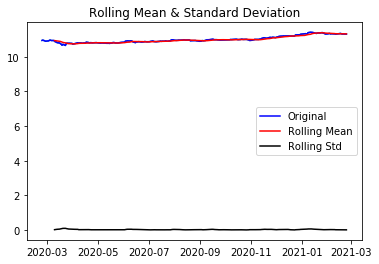

Results of Dickey-Fuller Test:
Test Statistic                  -0.120486
p-value                          0.947359
#Lags Used                       0.000000
Number of Observations Used    247.000000
Critical Value (1%)             -3.457105
Critical Value (5%)             -2.873314
Critical Value (10%)            -2.573044
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -5.900911e+00
p-value                        2.779531e-07
#Lags Used                     9.000000e+00
Number of Observations Used    2.080000e+02
Critical Value (1%)           -3.462186e+00
Critical Value (5%)           -2.875538e+00
Critical Value (10%)          -2.574231e+00
dtype: float64


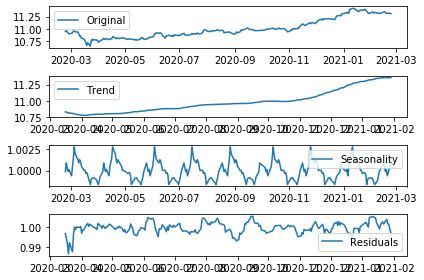

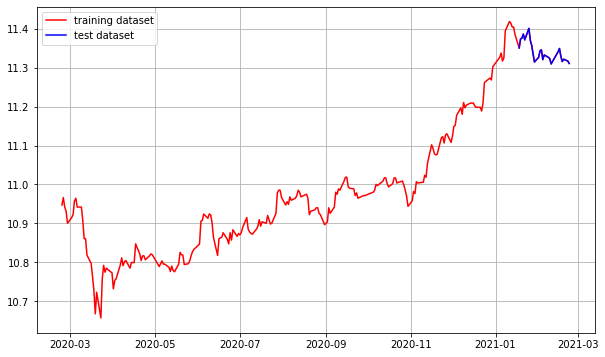

In [11]:
# 삼성전자
ts_log = preprocessing('005930.KS.csv')
Safety_analysis(ts_log)
splited_train_data, splited_test_data = data_split(ts_log)

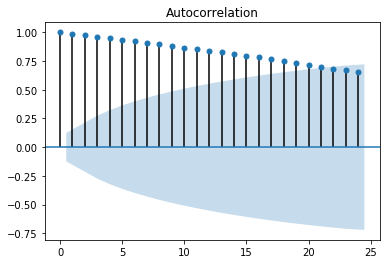

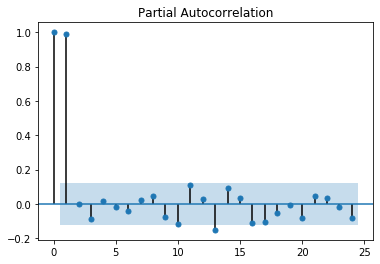

In [12]:
find_parameter(ts_log)

PACF가 1~2 이상인 구간에서 PACF는 거의 0에 가까워지고 있음.<br/>
따라서 p는 1로 설정함.<br/>

ACF는 점차적으로 감소하여 q를 0으로 둠.

Results of Dickey-Fuller Test:
Test Statistic                -1.603651e+01
p-value                        5.977986e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.460000e+02
Critical Value (1%)           -3.457215e+00
Critical Value (5%)           -2.873362e+00
Critical Value (10%)          -2.573070e+00
dtype: float64


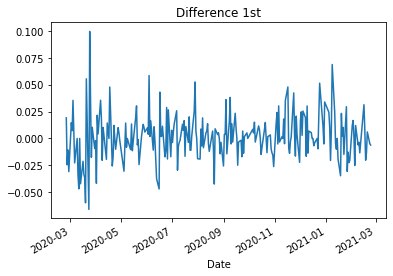

In [13]:
parameter_safety(ts_log)

1차 차분만 해도 안정한 상태를 보이는 것 같아 d는 1로 설정함. 

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  222
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 537.526
Method:                       css-mle   S.D. of innovations              0.021
Date:                Tue, 02 Mar 2021   AIC                          -1069.052
Time:                        15:37:02   BIC                          -1058.844
Sample:                             1   HQIC                         -1064.930
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0020      0.001      1.397      0.162      -0.001       0.005
ar.L1.D.Close    -0.0215      0.067     -0.321      0.748      -0.153       0.110
                                    Root

/home/ssac12/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/ssac12/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


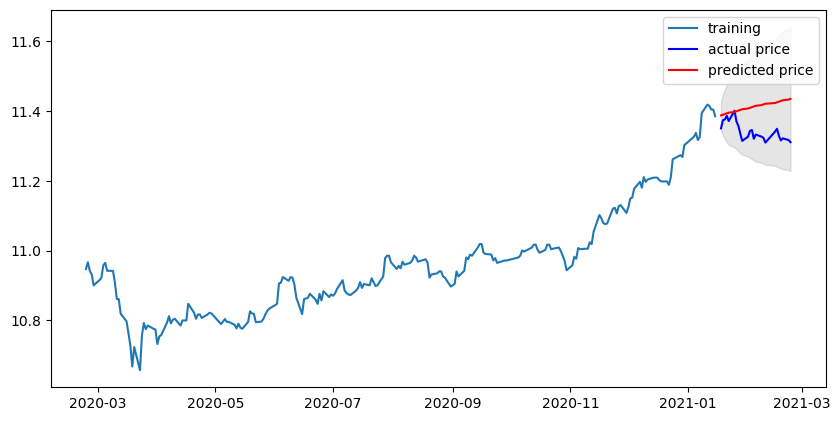

MSE:  46645304.09152185
MAE:  6052.033162127319
RMSE:  6829.736751260758
MAPE: 7.27%


In [14]:
fc = build_model(splited_train_data, splited_test_data,1,1,0)
accuracy_test(splited_test_data, fc)

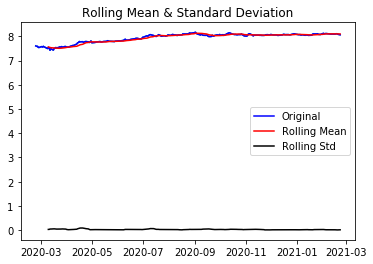

Results of Dickey-Fuller Test:
Test Statistic                  -2.017194
p-value                          0.279085
#Lags Used                       3.000000
Number of Observations Used    248.000000
Critical Value (1%)             -3.456996
Critical Value (5%)             -2.873266
Critical Value (10%)            -2.573019
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                  -5.406515
p-value                          0.000003
#Lags Used                       4.000000
Number of Observations Used    217.000000
Critical Value (1%)             -3.460849
Critical Value (5%)             -2.874953
Critical Value (10%)            -2.573919
dtype: float64


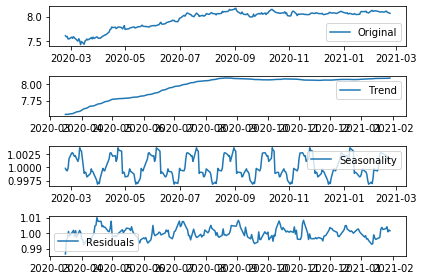

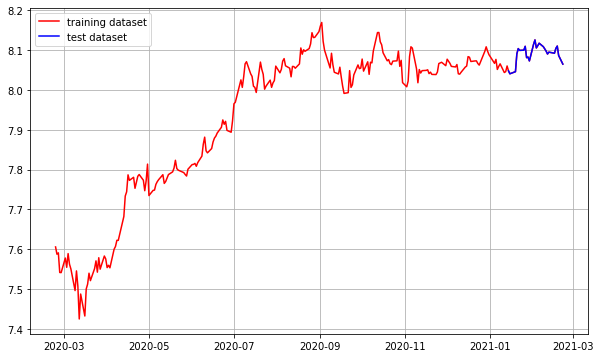

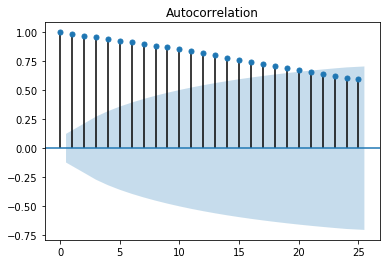

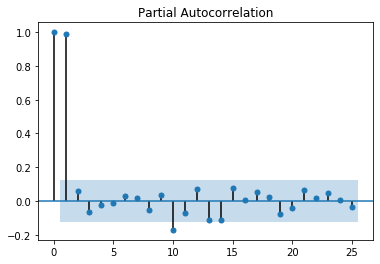

Results of Dickey-Fuller Test:
Test Statistic                -1.027517e+01
p-value                        3.907800e-18
#Lags Used                     2.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64
                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  225
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 516.058
Method:                       css-mle   S.D. of innovations              0.024
Date:                Tue, 02 Mar 2021   AIC                          -1026.115
Time:                        15:37:03   BIC                          -1015.867
Sample:                             1   HQIC                         -1021.979
                                                                              
              

/home/ssac12/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/ssac12/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


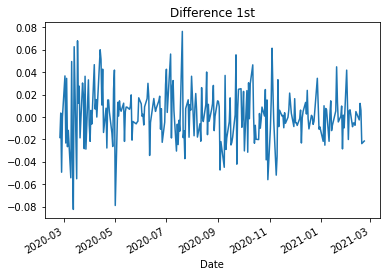

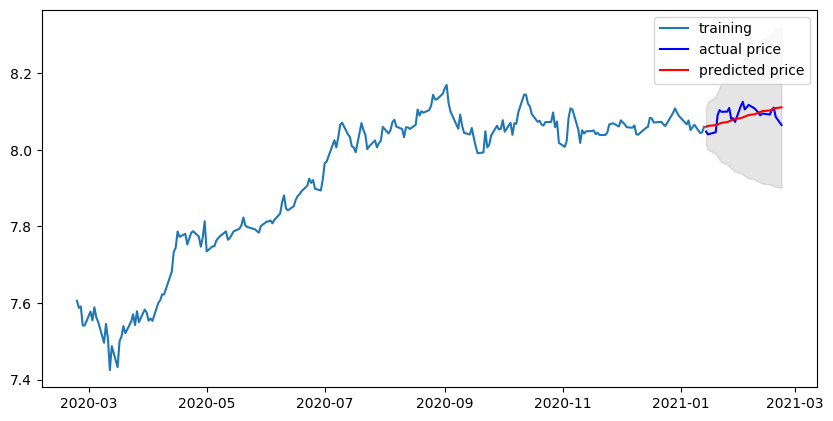

MSE:  5376.511219069224
MAE:  60.47595200159652
RMSE:  73.3246971972556
MAPE: 1.85%


In [15]:
# 아마존
ts_log = preprocessing('AMZN.csv')
Safety_analysis(ts_log)
splited_train_data, splited_test_data = data_split(ts_log)
find_parameter(ts_log)
parameter_safety(ts_log)

# 위와 마찬가지로 PACF를 통해 p=1, ACF를 통해 q=0, d차 차분을 통해 d를 1로 설정.
fc = build_model(splited_train_data, splited_test_data,1,1,0)
accuracy_test(splited_test_data, fc)

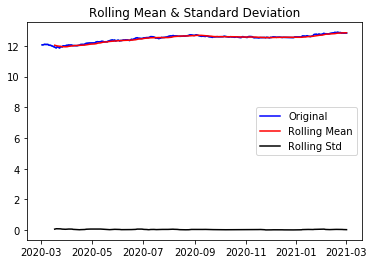

Results of Dickey-Fuller Test:
Test Statistic                  -1.030725
p-value                          0.741894
#Lags Used                       1.000000
Number of Observations Used    245.000000
Critical Value (1%)             -3.457326
Critical Value (5%)             -2.873410
Critical Value (10%)            -2.573096
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -6.745286e+00
p-value                        3.046052e-09
#Lags Used                     0.000000e+00
Number of Observations Used    2.160000e+02
Critical Value (1%)           -3.460992e+00
Critical Value (5%)           -2.875016e+00
Critical Value (10%)          -2.573952e+00
dtype: float64


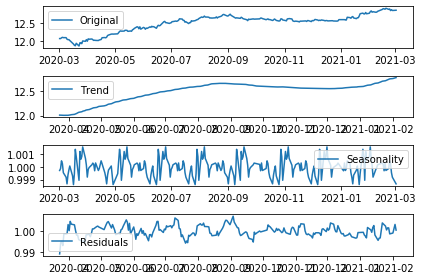

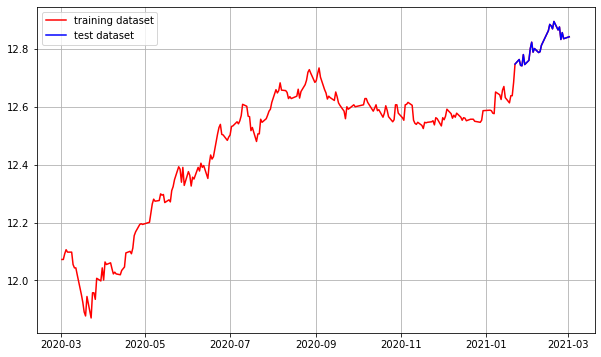

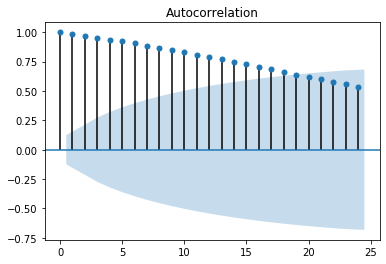

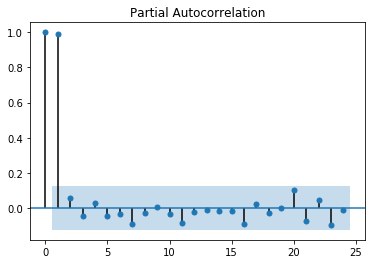

Results of Dickey-Fuller Test:
Test Statistic                -1.788160e+01
p-value                        3.000933e-30
#Lags Used                     0.000000e+00
Number of Observations Used    2.450000e+02
Critical Value (1%)           -3.457326e+00
Critical Value (5%)           -2.873410e+00
Critical Value (10%)          -2.573096e+00
dtype: float64
                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  221
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 494.308
Method:                       css-mle   S.D. of innovations              0.026
Date:                Tue, 02 Mar 2021   AIC                           -982.615
Time:                        15:40:32   BIC                           -972.421
Sample:                             1   HQIC                          -978.499
                                                                              
              

/home/ssac12/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/ssac12/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


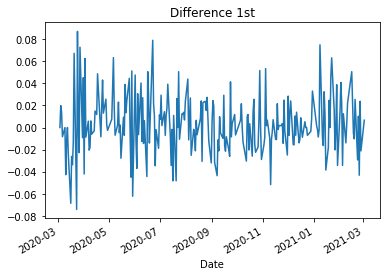

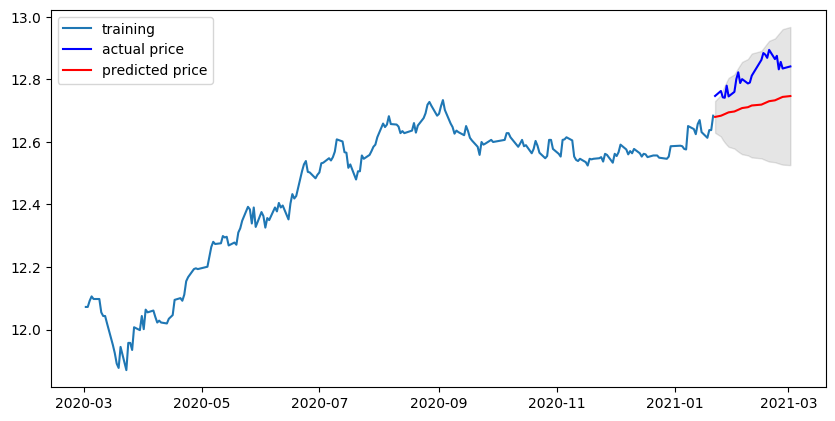

MSE:  1446881209.6934946
MAE:  35736.71986004863
RMSE:  38037.89176194568
MAPE: 9.57%


In [20]:
# Naver
ts_log = preprocessing('035420.KS.csv')
Safety_analysis(ts_log)
splited_train_data, splited_test_data = data_split(ts_log)
find_parameter(ts_log)
parameter_safety(ts_log)

# 위와 마찬가지로 PACF를 통해 p=1, ACF를 통해 q=0, d차 차분을 통해 d를 1로 설정.
fc = build_model(splited_train_data, splited_test_data,1,1,0)
accuracy_test(splited_test_data, fc)